# Keras Tuner
    library that helps in picking up the optimal set of hyperparameters for the TensorFlow program

**Keras Tuner is similar to grid search that we have in scikit learn**

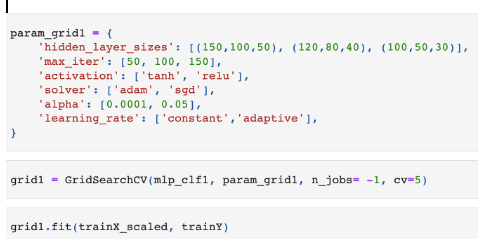

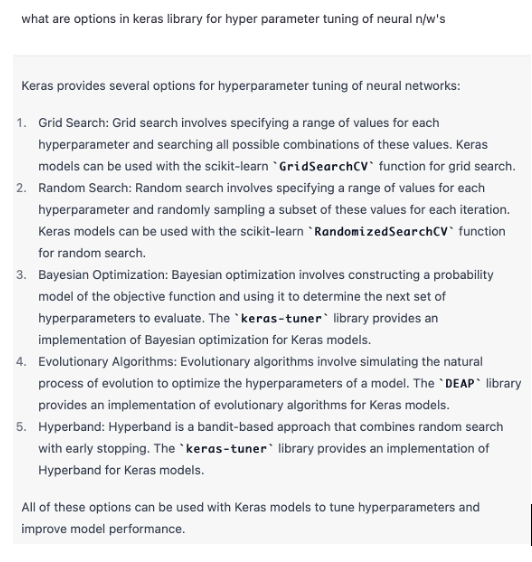

##### Hyperparameter tuning or hypertuning is the process of selecting the right set of hyperparameters for the machine learning (ML) algorithms

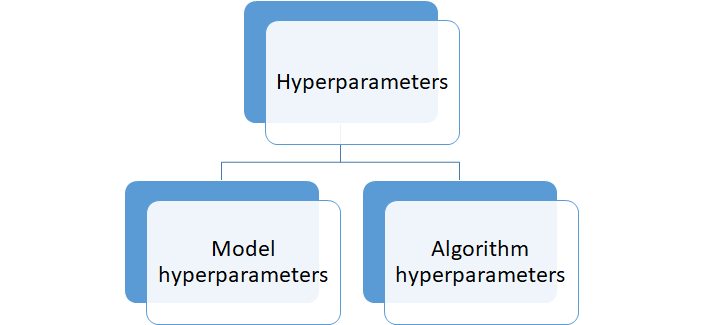

- **<font color=blue>Model Hyperarameters** are those which are related to architecture.
    
    
- <font color=blue>In case we r using some optimization algorithm and in that optimization algorithm if some parameter is used then we call that as **Algorithm hyperparameter.**

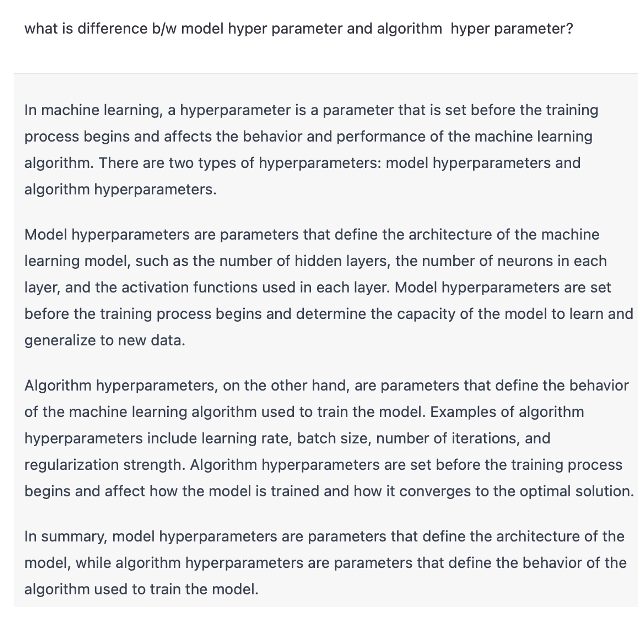

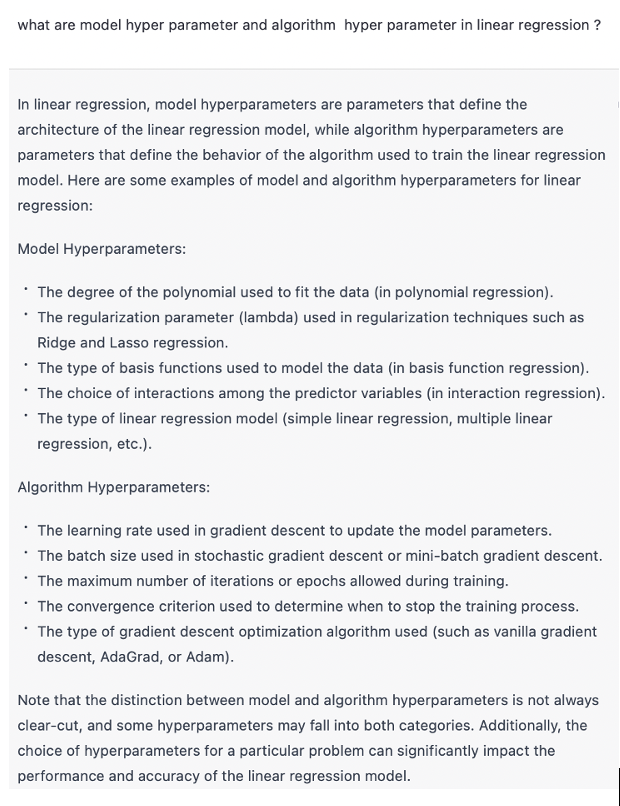

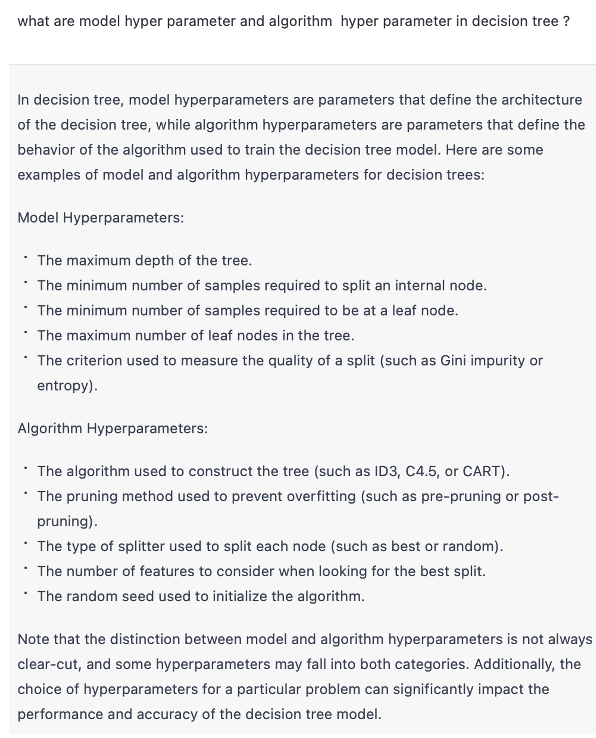

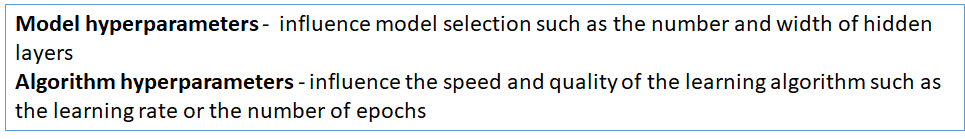

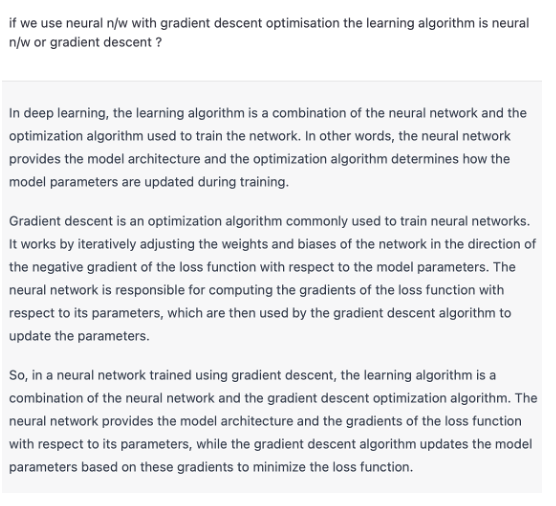

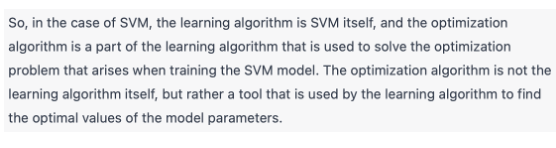

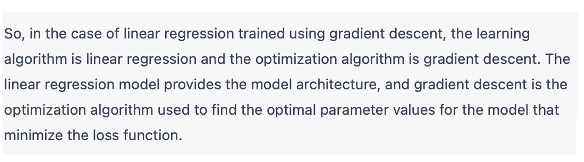

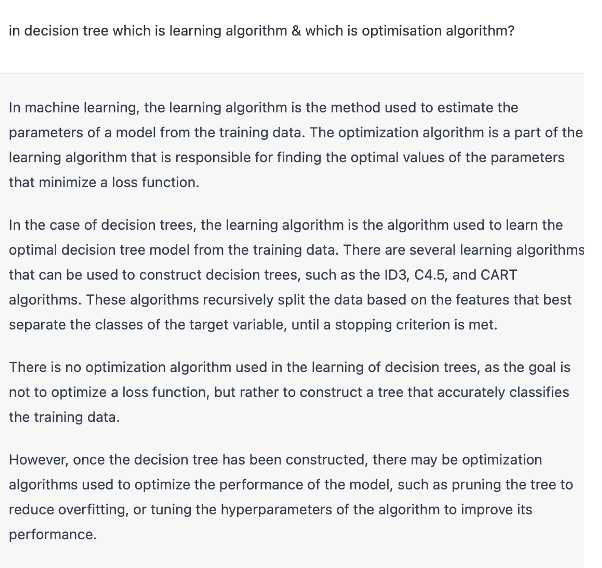

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras

Install and import the Keras Tuner.

In [2]:
#pip install -q -U keras-tuner

In [3]:
import keras_tuner as kt

## Dataset fashion MNIST

(https://github.com/zalandoresearch/fashion-mnist).

This dataset is well balanced, each class having almost equal number of samples.

In [4]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

In [5]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

## Define the model

While building a model for hypertuning, we define the hyperparameter search space in addition to the model architecture. 
The model that is set up for hypertuning is called a *hypermodel*.

hypermodel can be defined:

* By using a model builder function
* By subclassing the `HyperModel` class of the Keras Tuner API

**You can also use two pre-defined [HyperModel](https://keras.io/api/keras_tuner/hypermodels/) classes - [HyperXception](https://keras.io/api/keras_tuner/hypermodels/hyper_xception/) and [HyperResNet](https://keras.io/api/keras_tuner/hypermodels/hyper_resnet/) for computer vision applications.**

**Usually we build the function in term of function so we can keep on doing changes in it with different hyperparameters**

function called modelbuilder is defined. It returns a compiled model and uses the defined hyperparameters inline to hypertune the model.

In [6]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
   # First layer flatten cz processing image through ANN, we need to vectorize the 2d data

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32) ## number of neurons
    
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) ### 

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

## Instantiate the tuner and perform hypertuning

### Instantiate the tuner to perform the hypertuning.**The Keras Tuner has four tuners available - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`.**

All 4 types of Keras tuner will try to fine tune the parameter i.e provide best possible parameters out of all given parameter space.Alternative to each other try with which tuner get better accuracy on model.

In this tutorial, Hyperband tuner is used.

To instantiate the Hyperband tuner, you must specify the hypermodel, the `objective` to optimize and the maximum number of epochs to train (`max_epochs`).

In [7]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt/tuner0.json


    The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. 
    This is done using a sports championship style bracket. 
    The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. 

**Create a callback to stop training early after reaching a certain value for the validation loss.**

In [8]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

Run the hyperparameter search. The arguments for the search method are the same as those used for `tf.keras.model.fit` in addition to the callback above.

In [9]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 224 and the optimal learning rate for the optimizer
is 0.001.



## Train the model - without Early Stopping


Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [10]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(img_train, 
                    label_train, 
                    epochs=50, 
                    validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))

Epoch 1/50


2023-04-01 20:18:56.325653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1500/1500 [==============================] - 2s 1ms/step - loss: 0.5032 - accuracy: 0.8229 - val_loss: 0.4335 - val_accuracy: 0.8443
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3787 - accuracy: 0.8638 - val_loss: 0.3904 - val_accuracy: 0.8529
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3388 - accuracy: 0.8769 - val_loss: 0.3601 - val_accuracy: 0.8636
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3127 - accuracy: 0.8850 - val_loss: 0.3522 - val_accuracy: 0.8721
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2948 - accuracy: 0.8909 - val_loss: 0.3344 - val_accuracy: 0.8802
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2797 - accuracy: 0.8964 - val_loss: 0.3339 - val_accuracy: 0.8782
Epoch 7/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2648 - accuracy: 0.9019 - val_loss: 0.3304 - val_accuracy: 0.8809
Epo

In [11]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

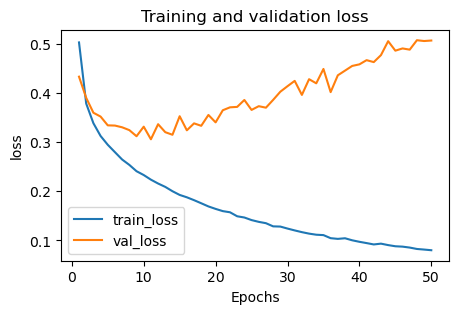

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))

plot_metric(history, 'loss')

In [13]:
eva_result = model.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eva_result)

313/313 [==============================] - 0s 639us/step - loss: 0.5706 - accuracy: 0.8856
[test loss, test accuracy]: [0.5706089735031128, 0.8855999708175659]


## Train the model - with Early Stopping


In [14]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model1 = tuner.hypermodel.build(best_hps)
history1 = model1.fit(img_train, 
                    label_train, 
                    epochs=50, 
                    validation_split=0.2,
                    callbacks=[stop_early])


Epoch 1/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5036 - accuracy: 0.8238 - val_loss: 0.4190 - val_accuracy: 0.8480
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3771 - accuracy: 0.8641 - val_loss: 0.3872 - val_accuracy: 0.8580
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3372 - accuracy: 0.8755 - val_loss: 0.3446 - val_accuracy: 0.8752
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3111 - accuracy: 0.8836 - val_loss: 0.3433 - val_accuracy: 0.8763
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2917 - accuracy: 0.8918 - val_loss: 0.3215 - val_accuracy: 0.8823
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2773 - accuracy: 0.8975 - val_loss: 0.3281 - val_accuracy: 0.8804
Epoch 7/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2647 - accuracy: 0.9014 - val_loss: 0.3050 - val_accuracy:

In [15]:

val_acc_per_epoch1 = history1.history['val_accuracy']
best_epoch1 = val_acc_per_epoch1.index(max(val_acc_per_epoch1)) + 1

print('Best epoch: %d' % (best_epoch1,))

Best epoch: 7


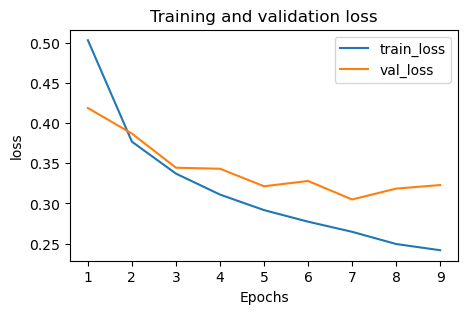

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))

plot_metric(history1, 'loss')

### Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [17]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(img_train, label_train, epochs=best_epoch1, validation_split=0.2)

Epoch 1/7
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5072 - accuracy: 0.8209 - val_loss: 0.3948 - val_accuracy: 0.8615
Epoch 2/7
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3805 - accuracy: 0.8622 - val_loss: 0.3742 - val_accuracy: 0.8658
Epoch 3/7
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3399 - accuracy: 0.8741 - val_loss: 0.3535 - val_accuracy: 0.8717
Epoch 4/7
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3123 - accuracy: 0.8833 - val_loss: 0.3342 - val_accuracy: 0.8807
Epoch 5/7
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2943 - accuracy: 0.8916 - val_loss: 0.3573 - val_accuracy: 0.8779
Epoch 6/7
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2782 - accuracy: 0.8968 - val_loss: 0.3081 - val_accuracy: 0.8913
Epoch 7/7
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2628 - accuracy: 0.9012 - val_loss: 0.3399 - val_accuracy: 0.8784

#### Evaluate the hypermodel on the test data.

In [18]:
eval_result = hypermodel.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 0s 636us/step - loss: 0.3590 - accuracy: 0.8699
[test loss, test accuracy]: [0.3590426445007324, 0.8698999881744385]


## Hyperparameter Tuning With Keras Tuners Arguments Explanations

## Bayesian Optimization Tuning Implementation With Keras

In [19]:
# kt.tuners.bayesian.BayesianOptimization(hypermodel, objective, max_trials, num_initial_points=2, seed=None, 
# hyperparameters=None, tune_new_entries=True, allow_new_entries=True, **kwargs)


Arguments Explanation:

    hypermodel: Instance of HyperModel class (or callable that takes hyperparameters and returns a Model instance).
    
    objective: String. Name of model metric to minimize or maximize, e.g. "val_accuracy".
    
    max_trials: Int. Total number of trials (model configurations) to test at most. Note that the oracle may interrupt the search before max_trial models have been tested if the search space has been exhausted.
    
    num_initial_points: Int. The number of randomly generated samples as initial training data for Bayesian optimization.
    
    alpha: Float or array-like. Value added to the diagonal of the kernel matrix during fitting.
    
    beta: Float. The balancing factor of exploration and exploitation. The larger it is, the more explorative it is.
    
    seed: Int. Random seed.
    
    hyperparameters: HyperParameters class instance. Used to override (or register in advance) hyperparamters in the search space.
    
    tune_new_entries: Whether hyperparameter entries that are requested by the hypermodel but that were not specified in hyperparameters should be added to the search space, or not. If not, then the default value for these parameters will be used.
    
    allow_new_entries: Whether the hypermodel is allowed to request hyperparameter entries not listed in hyperparameters.
    
    **kwargs: Keyword arguments relevant to all Tuner subclasses. Please see the docstring for Tuner.

## Hyperband tuning implementation with Keras


kerastuner.tuners.hyperband.Hyperband(hypermodel, objective, max_epochs, factor=3, hyperband_iterations=1, seed=None, 
hyperparameters=None, tune_new_entries=True, allow_new_entries=True, **kwargs)

**Arguments Explanation**

    hypermodel: Instance of HyperModel class (or callable that takes hyperparameters and returns a Model instance).

    objective: String. Name of model metric to minimize or maximize, e.g. "val_accuracy".

    max_epochs: Int. The maximum number of epochs to train one model. It is recommended to set this to a value slightly higher than the expected time to convergence for your largest Model, and to use early stopping during training (for example, via tf.keras.callbacks.EarlyStopping).

    factor: Int. Reduction factor for the number of epochs and number of models for each bracket.

    hyperband_iterations: Int >= 1. The number of times to iterate over the full Hyperband algorithm. One iteration will run approximately max_epochs * (math.log(max_epochs, factor) ** 2) cumulative epochs across all trials. It is recommended to set this to as high a value as is within your resource budget.

    seed: Int. Random seed.

    hyperparameters: HyperParameters class instance. Can be used to override (or register in advance) hyperparamters in the search space.

    tune_new_entries: Whether hyperparameter entries that are requested by the hypermodel but that were not specified in hyperparameters should be added to the search space, or not. If not, then the default value for these parameters will be used.

    allow_new_entries: Whether the hypermodel is allowed to request hyperparameter entries not listed in hyperparameters.

    **kwargs: Keyword arguments relevant to all Tuner subclasses. Please see the docstring for Tuner.

## Random search tuning implementation with Keras


kerastuner.tuners.randomsearch.RandomSearch(hypermodel, objective, max_trials, seed=None, 
hyperparameters=None, tune_new_entries=True, allow_new_entries=True, **kwargs)

Arguments Explanation:

    hypermodel: Instance of HyperModel class (or callable that takes hyperparameters and returns a Model instance).

    objective: String. Name of model metric to minimize or maximize, e.g. "val_accuracy".

    max_trials: Int. Total number of trials (model configurations) to test at most. Note that the oracle may interrupt the search before max_trial models have been tested.

    seed: Int. Random seed.

    hyperparameters: HyperParameters class instance. Can be used to override (or register in advance) hyperparamters in the search space.

    tune_new_entries: Whether hyperparameter entries that are requested by the hypermodel but that were not specified in hyperparameters should be added to the search space, or not. If not, then the default value for these parameters will be used.

    allow_new_entries: Whether the hypermodel is allowed to request hyperparameter entries not listed in hyperparameters.

    **kwargs: Keyword arguments relevant to all Tuner subclasses. Please see the docstring for Tuner.